In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [2]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


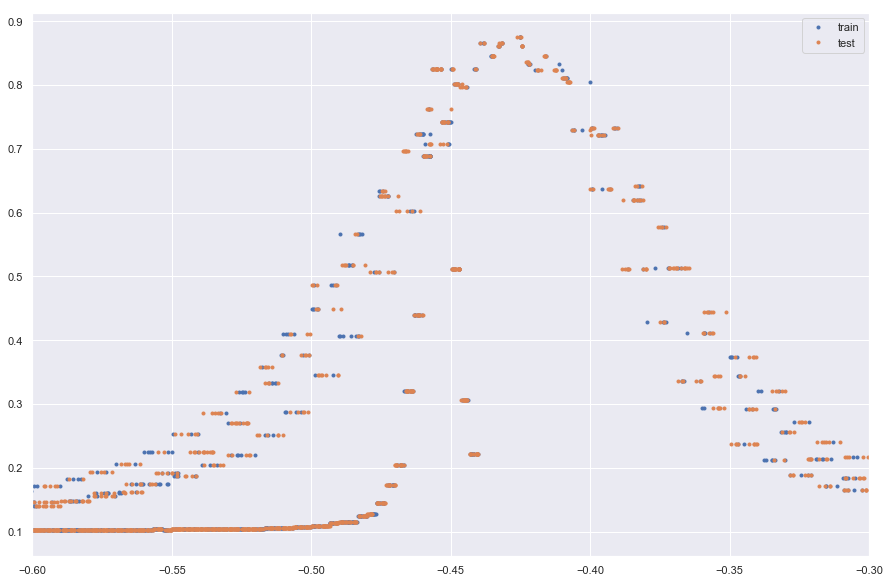

In [23]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full_1 = pd.read_csv('Data/May/training_merged_4.csv', header=0)
df_train_full_1.drop_duplicates(subset=None, inplace=True)
df_train_pseudo = pd.read_csv('Data/May/pseudo_trainingsdata_x.csv', header=0, names=['x', 'time', 'energy', 'y', 'sigma'])
df_train_full = pd.concat([df_train_full_1, df_train_pseudo], axis=0, ignore_index=True)


## Select only the data with a minimum intensity value 
intensity_min = .2
energyloss_max = -0.3
df_train_full = df_train_full[df_train_full['x'] < energyloss_max]

## Find the value where intensity of the 10 ms, 200kev is 20%. This is 0.440306

indexNames = df_train_full[ (df_train_full['time'] == .1) & (df_train_full['energy'] ==2)& (df_train_full['x'] > -0.44) ].index
df_train_full.drop(indexNames, inplace=True)

df_train, df_test = train_test_split(df_train_full, test_size=0.4)
train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)

predictions = make_model(x,1)

#plt.plot(df_train_full['x'],df_train_full['y'],'.')

plt.figure(figsize=(15,10))
plt.xlim([-0.6, -0.3])
plt.plot(df_test['x'], df_test['y'], '.', label='train')
plt.plot(df_train['x'], df_train['y'], '.', label='test')
plt.legend()



## Set a restriction for the minimum relative error

In [24]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.0001
treshold_error_index = np.where(relative_error >= treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)


## Create MC replicas

In [25]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

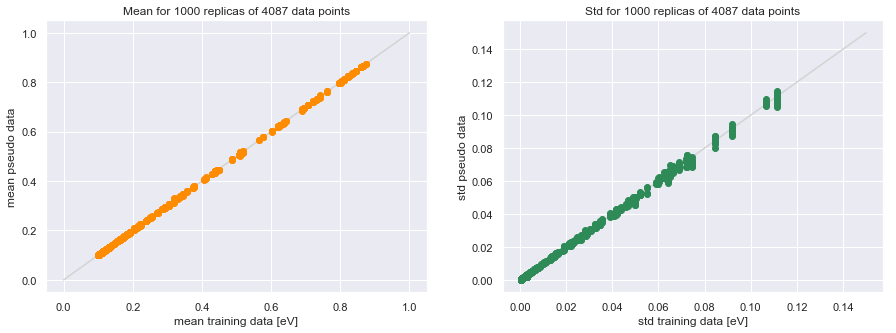

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [27]:
## Beam energy interpolation

import random
N_pred = 4000
part1 = 1000
interpol_energy1 = .6 #*100 keV
interpol_energy2 = 2 #*100 keV
interpol_energy3 = .4
interpol_energy4 = 2.2
interpol_time = .1

predict_x = np.zeros(shape=(N_pred, 3))
predict_x[:part1,0] = np.linspace(-1,1,part1)
predict_x[part1:2*part1, 0] = np.linspace(-1,1,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(-1,1,part1)
predict_x[3*part1:, 0] = np.linspace(-1,1,part1)
predict_x[:,1] = interpol_time * np.ones(N_pred)
predict_x[:part1,2] = interpol_energy1 * np.ones(part1)
predict_x[part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:,2] = interpol_energy4 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [28]:
import time
from datetime import datetime

training_epochs = 60000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)
saver = tf.train.Saver(max_to_keep=50)

i = 0
Nrep = 20

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    # Create a saver.

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            
            
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
            

            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                break
        
            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch
                
        best_iteration = np.argmin(array_test) 
        best_epoch = best_iteration * display_step
        best_model = 'Models/my-model.ckpt-%(s)s' % {'s': best_epoch}
        
        print("Optimization Finished! Best model after epoch %(s)s" % {'s': best_epoch})
        
        
        #saver = tf.train.import_meta_graph('my-model-8000.meta')
        saver.restore(sess, best_model)
        
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    chi_array.append(d[-1])

    best_chi = np.where(array_test == min(array_test))
    np.savetxt('Data/Results/%(date)s/xyp1p2_all_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/extrapolation_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Start training on 4087 and validating on 2725 samples
Epoch: 0001 | Training cost= 14121.333007812 | Validation cost= 17329.048828125
Epoch: 1001 | Training cost= 34.229793549 | Validation cost= 32.553741455
Epoch: 2001 | Training cost= 31.267116547 | Validation cost= 29.949678421
Epoch: 3001 | Training cost= 26.422008514 | Validation cost= 25.431020737
Epoch: 4001 | Training cost= 24.014797211 | Validation cost= 25.360057831
Epoch: 5001 | Training cost= 18.275129318 | Validation cost= 17.545289993
Epoch: 6001 | Training cost= 17.361837387 | Validation cost= 16.519247055
Epoch: 7001 | Training cost= 16.746923447 | Validation cost= 15.887994766
Epoch: 8001 | Training cost= 15.572311401 | Validation cost= 14.744303703
Epoch: 9001 | Training cost= 14.547796249 | Validation cost= 13.728915215
Epoch: 10001 | Training cost= 13.823625565 | Validation cost= 12.971316338
Epoch: 11001 | Training cost= 12.402981758 | Validation cost= 11.723202705
Epoch: 12001 | Training cost= 4.496323109 | Valida

Epoch: 39001 | Training cost= 3.809209108 | Validation cost= 3.408149481
Epoch: 40001 | Training cost= 1.140228868 | Validation cost= 1.240872860
Epoch: 41001 | Training cost= 1.163236499 | Validation cost= 1.286041379
Epoch: 42001 | Training cost= 14.759573936 | Validation cost= 7.880378246
Epoch: 43001 | Training cost= 1.136311769 | Validation cost= 1.231438994
Epoch: 44001 | Training cost= 1.132566452 | Validation cost= 1.229695082
Epoch: 45001 | Training cost= 1.131151915 | Validation cost= 1.228803873
Epoch: 46001 | Training cost= 1.130655289 | Validation cost= 1.227357507
Epoch: 47001 | Training cost= 1.129325032 | Validation cost= 1.227514863
Epoch: 48001 | Training cost= 1.138303876 | Validation cost= 1.245856643
Epoch: 49001 | Training cost= 1.127504945 | Validation cost= 1.227037549
Epoch: 50001 | Training cost= 1.140768170 | Validation cost= 1.243404388
Epoch: 51001 | Training cost= 1.130734444 | Validation cost= 1.229179621
Epoch: 52001 | Training cost= 1.126087070 | Valida

Epoch: 25001 | Training cost= 1.707803249 | Validation cost= 1.725872040
Epoch: 26001 | Training cost= 1.270006180 | Validation cost= 1.385623574
Epoch: 27001 | Training cost= 1.317512393 | Validation cost= 1.460358262
Epoch: 28001 | Training cost= 1.252564430 | Validation cost= 1.277694345
Epoch: 29001 | Training cost= 1.201103926 | Validation cost= 1.262624860
Epoch: 30001 | Training cost= 1.192471504 | Validation cost= 1.254945040
Epoch: 31001 | Training cost= 1.494089603 | Validation cost= 1.469717741
Epoch: 32001 | Training cost= 1.181112528 | Validation cost= 1.244900584
Epoch: 33001 | Training cost= 1.185312510 | Validation cost= 1.242363095
Epoch: 34001 | Training cost= 1.171983123 | Validation cost= 1.237007022
Epoch: 35001 | Training cost= 1.532336473 | Validation cost= 2.278396368
Epoch: 36001 | Training cost= 1.161969543 | Validation cost= 1.227049708
Epoch: 37001 | Training cost= 1.273159742 | Validation cost= 1.269653559
Epoch: 38001 | Training cost= 1.151277661 | Validat

Epoch: 11001 | Training cost= 17.203960419 | Validation cost= 16.713859558
Epoch: 12001 | Training cost= 16.713535309 | Validation cost= 16.211456299
Epoch: 13001 | Training cost= 25.841587067 | Validation cost= 16.094303131
Epoch: 14001 | Training cost= 39.280673981 | Validation cost= 55.850700378
Epoch: 15001 | Training cost= 6.063071728 | Validation cost= 5.796733856
Epoch: 16001 | Training cost= 4.163624763 | Validation cost= 3.801681757
Epoch: 17001 | Training cost= 3.877830744 | Validation cost= 3.543627024
Epoch: 18001 | Training cost= 4.943802834 | Validation cost= 3.207442284
Epoch: 19001 | Training cost= 2.523466825 | Validation cost= 2.513546705
Epoch: 20001 | Training cost= 2.285421848 | Validation cost= 2.301470518
Epoch: 21001 | Training cost= 2.093871832 | Validation cost= 2.111861467
Epoch: 22001 | Training cost= 1.836370230 | Validation cost= 1.857143641
Epoch: 23001 | Training cost= 2.154892445 | Validation cost= 2.661200285
Epoch: 24001 | Training cost= 1.324876904 |

Optimization Finished! Best model after epoch 58000
INFO:tensorflow:Restoring parameters from Models/my-model.ckpt-58000
Elapsed time: 1178.3869018554688
6
Start training on 4087 and validating on 2725 samples
Epoch: 0001 | Training cost= 1654749.375000000 | Validation cost= 750504.062500000
Epoch: 1001 | Training cost= 35.030429840 | Validation cost= 33.311534882
Epoch: 2001 | Training cost= 34.058750153 | Validation cost= 32.213424683
Epoch: 3001 | Training cost= 33.819480896 | Validation cost= 32.047657013
Epoch: 4001 | Training cost= 33.508670807 | Validation cost= 31.812259674
Epoch: 5001 | Training cost= 32.984649658 | Validation cost= 31.358188629
Epoch: 6001 | Training cost= 32.182319641 | Validation cost= 30.598024368
Epoch: 7001 | Training cost= 31.454566956 | Validation cost= 30.044368744
Epoch: 8001 | Training cost= 27.628997803 | Validation cost= 26.182786942
Epoch: 9001 | Training cost= 25.845319748 | Validation cost= 24.569292068
Epoch: 10001 | Training cost= 25.55445861

Epoch: 46001 | Training cost= 2.581857681 | Validation cost= 1.705518603
Epoch: 47001 | Training cost= 1.155984759 | Validation cost= 1.232365847
Epoch: 48001 | Training cost= 2.739733458 | Validation cost= 1.780382395
Epoch: 49001 | Training cost= 1.154155850 | Validation cost= 1.231747031
Epoch: 50001 | Training cost= 1.367451906 | Validation cost= 1.245254755
Epoch: 51001 | Training cost= 1.152011752 | Validation cost= 1.231636047
Epoch: 52001 | Training cost= 1.151584983 | Validation cost= 1.231027603
Epoch: 53001 | Training cost= 1.149774075 | Validation cost= 1.231549740
Epoch: 54001 | Training cost= 4.539464474 | Validation cost= 3.319075108
Epoch: 55001 | Training cost= 1.149325728 | Validation cost= 1.252040625
Epoch: 56001 | Training cost= 1.146191239 | Validation cost= 1.232475042
Epoch: 57001 | Training cost= 1.146105647 | Validation cost= 1.234285712
Epoch: 58001 | Training cost= 1.148797512 | Validation cost= 1.240315080
Epoch: 59001 | Training cost= 1.145448208 | Validat

Epoch: 32001 | Training cost= 1.171101213 | Validation cost= 1.221863747
Epoch: 33001 | Training cost= 1.177973509 | Validation cost= 1.230344534
Epoch: 34001 | Training cost= 9.907493591 | Validation cost= 17.376880646
Epoch: 35001 | Training cost= 1.163400769 | Validation cost= 1.220597625
Epoch: 36001 | Training cost= 1.441632867 | Validation cost= 1.739924550
Epoch: 37001 | Training cost= 1.153398871 | Validation cost= 1.211214185
Epoch: 38001 | Training cost= 1.151737452 | Validation cost= 1.209877014
Epoch: 39001 | Training cost= 17.054006577 | Validation cost= 16.985202789
Epoch: 40001 | Training cost= 1.147915483 | Validation cost= 1.207804322
Epoch: 41001 | Training cost= 1.145863771 | Validation cost= 1.207781911
Epoch: 42001 | Training cost= 1.147045732 | Validation cost= 1.207403064
Epoch: 43001 | Training cost= 1.143643737 | Validation cost= 1.205862403
Epoch: 44001 | Training cost= 1.144206285 | Validation cost= 1.205169916
Epoch: 45001 | Training cost= 1.141903400 | Vali

Epoch: 18001 | Training cost= 1.700877428 | Validation cost= 1.687854767
Epoch: 19001 | Training cost= 1.634200454 | Validation cost= 1.627390862
Epoch: 20001 | Training cost= 1.582294226 | Validation cost= 1.579395771
Epoch: 21001 | Training cost= 1.531000376 | Validation cost= 1.530919909
Epoch: 22001 | Training cost= 1.369184256 | Validation cost= 1.396893859
Epoch: 23001 | Training cost= 1.318588734 | Validation cost= 1.333932281
Epoch: 24001 | Training cost= 1.234513760 | Validation cost= 1.276986599
Epoch: 25001 | Training cost= 1.256152511 | Validation cost= 1.341350198
Epoch: 26001 | Training cost= 1.199144244 | Validation cost= 1.245591521
Epoch: 27001 | Training cost= 1.222504735 | Validation cost= 1.298097372
Epoch: 28001 | Training cost= 1.184797049 | Validation cost= 1.229866385
Epoch: 29001 | Training cost= 1.172928452 | Validation cost= 1.218072295
Epoch: 30001 | Training cost= 4.153596401 | Validation cost= 4.676027775
Epoch: 31001 | Training cost= 1.159522176 | Validat

Epoch: 4001 | Training cost= 31.424022675 | Validation cost= 30.072250366
Epoch: 5001 | Training cost= 27.456214905 | Validation cost= 26.359886169
Epoch: 6001 | Training cost= 29.936494827 | Validation cost= 34.211288452
Epoch: 7001 | Training cost= 23.385421753 | Validation cost= 22.409717560
Epoch: 8001 | Training cost= 21.974811554 | Validation cost= 21.077529907
Epoch: 9001 | Training cost= 20.483757019 | Validation cost= 19.640501022
Epoch: 10001 | Training cost= 19.213571548 | Validation cost= 18.351341248
Epoch: 11001 | Training cost= 18.402450562 | Validation cost= 17.487146378
Epoch: 12001 | Training cost= 17.963838577 | Validation cost= 17.013164520
Epoch: 13001 | Training cost= 17.689632416 | Validation cost= 16.722097397
Epoch: 14001 | Training cost= 17.102508545 | Validation cost= 16.064121246
Epoch: 15001 | Training cost= 15.974790573 | Validation cost= 14.830142021
Epoch: 16001 | Training cost= 46.044643402 | Validation cost= 46.855972290
Epoch: 17001 | Training cost= 7

Epoch: 53001 | Training cost= 1.132465243 | Validation cost= 1.178596854
Epoch: 54001 | Training cost= 1.127156258 | Validation cost= 1.168107748
Epoch: 55001 | Training cost= 1.126711488 | Validation cost= 1.168135285
Epoch: 56001 | Training cost= 1.243979931 | Validation cost= 1.225584865
Epoch: 57001 | Training cost= 1.217828751 | Validation cost= 1.521629214
Epoch: 58001 | Training cost= 4.110886097 | Validation cost= 1.606911421
Epoch: 59001 | Training cost= 1.124647021 | Validation cost= 1.166485786
Optimization Finished! Best model after epoch 59000
INFO:tensorflow:Restoring parameters from Models/my-model.ckpt-59000
Elapsed time: 2674.477618932724
15
Start training on 4087 and validating on 2725 samples
Epoch: 0001 | Training cost= 735326.750000000 | Validation cost= 334023.156250000
Epoch: 1001 | Training cost= 35.943992615 | Validation cost= 34.358181000
Epoch: 2001 | Training cost= 34.315582275 | Validation cost= 32.844123840
Epoch: 3001 | Training cost= 33.204551697 | Valid

Epoch: 39001 | Training cost= 1.170250297 | Validation cost= 1.367926836
Epoch: 40001 | Training cost= 1.131381392 | Validation cost= 1.192583084
Epoch: 41001 | Training cost= 1.577340961 | Validation cost= 1.203728318
Epoch: 42001 | Training cost= 2.470844746 | Validation cost= 4.909499168
Epoch: 43001 | Training cost= 1.326158881 | Validation cost= 1.617290139
Epoch: 44001 | Training cost= 1.324903846 | Validation cost= 1.382432699
Epoch: 45001 | Training cost= 1.115544200 | Validation cost= 1.181192040
Epoch: 46001 | Training cost= 1.116629601 | Validation cost= 1.181706071
Epoch: 47001 | Training cost= 1.121941924 | Validation cost= 1.205089808
Epoch: 48001 | Training cost= 1.479790449 | Validation cost= 1.580188990
Epoch: 49001 | Training cost= 5.939618587 | Validation cost= 7.845607758
Epoch: 50001 | Training cost= 1.108790278 | Validation cost= 1.179495811
Epoch: 51001 | Training cost= 2.137379169 | Validation cost= 1.890335560
Epoch: 52001 | Training cost= 1.107556343 | Validat

Epoch: 25001 | Training cost= 1.663205624 | Validation cost= 1.666800261
Epoch: 26001 | Training cost= 1.895343781 | Validation cost= 2.017266989
Epoch: 27001 | Training cost= 1.574653864 | Validation cost= 1.582971931
Epoch: 28001 | Training cost= 33.606361389 | Validation cost= 43.165161133
Epoch: 29001 | Training cost= 1.474398613 | Validation cost= 1.491989017
Epoch: 30001 | Training cost= 1.419073701 | Validation cost= 1.439364314
Epoch: 31001 | Training cost= 1.382578492 | Validation cost= 1.409371376
Epoch: 32001 | Training cost= 1.334872723 | Validation cost= 1.365141749
Epoch: 33001 | Training cost= 1.297180891 | Validation cost= 1.323817611
Epoch: 34001 | Training cost= 1.240969181 | Validation cost= 1.281211972
Epoch: 35001 | Training cost= 1.231660843 | Validation cost= 1.273082852
Epoch: 36001 | Training cost= 1.228673100 | Validation cost= 1.271282315
Epoch: 37001 | Training cost= 1.243594289 | Validation cost= 1.276316047
Epoch: 38001 | Training cost= 1.218499303 | Valid

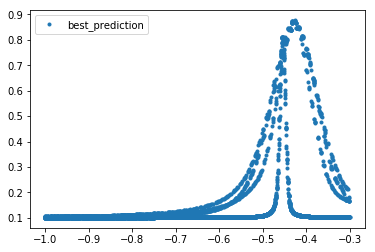

In [107]:
plt.plot(train_x[:,0], predictions_values, '.', label='best_prediction')
#plt.plot(train_x[:,0], (predictions_values_0), '.', label='final')
plt.legend()

### Plot outputs

In [340]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


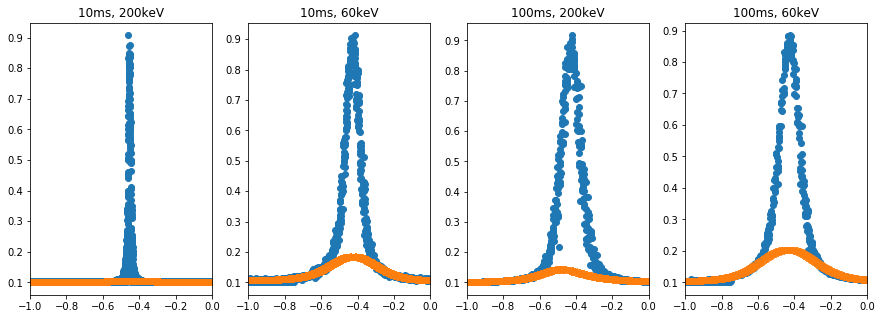

In [16]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

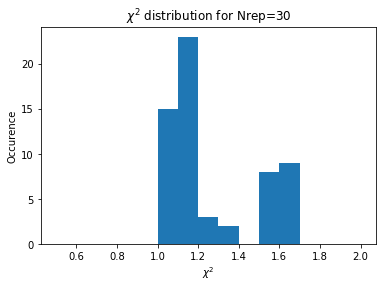

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

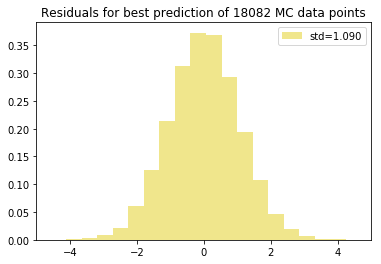

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

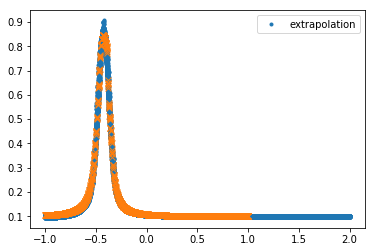

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

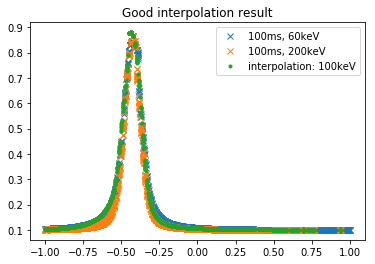

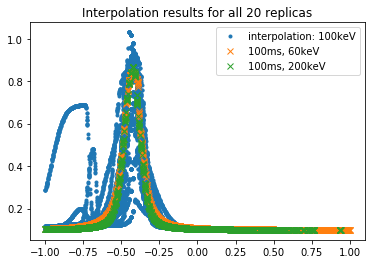

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)